In [2]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for clean plots
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = False
%matplotlib inline

In [7]:
# Cell 2: Load data
# Replace with your actual file path
df = pd.read_csv('train_val_2001_2021.csv', low_memory=False)

df.head()

,year,month,RectifHyd_MWh,mode,Latitude,Longitude,nerc_region,Primary Purpose,Dam Height (Ft),NID Height (Ft),...,NID Storage (Acre-Ft),Max Storage (Acre-Ft),Normal Storage (Acre-Ft),Surface Area (Acres),Drainage Area (Sq Miles),Division_ID,tmin,tmax,tavg,pcpn
0,2001,1,31321.0233,Storage,33.4586,-87.356,SERC,Navigation,44.0,111.0,...,296000.0,296000.0,269215.0,9245.0,3981.0,108,35.2,57.8,46.5,3.77
1,2001,2,35335.8614,Storage,33.4586,-87.356,SERC,Navigation,44.0,111.0,...,296000.0,296000.0,269215.0,9245.0,3981.0,108,47.4,68.4,57.9,2.52
2,2001,3,32962.4433,Storage,33.4586,-87.356,SERC,Navigation,44.0,111.0,...,296000.0,296000.0,269215.0,9245.0,3981.0,108,46.6,67.7,57.2,9.98
3,2001,4,27712.9919,Storage,33.4586,-87.356,SERC,Navigation,44.0,111.0,...,296000.0,296000.0,269215.0,9245.0,3981.0,108,56.7,79.8,68.2,1.14
4,2001,5,19356.5349,Storage,33.4586,-87.356,SERC,Navigation,44.0,111.0,...,296000.0,296000.0,269215.0,9245.0,3981.0,108,61.4,85.8,73.6,1.37


In [18]:
# Cell 3: Create datetime and define dam periods
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.sort_values(['Division_ID', 'date']).reset_index(drop=True)

# Define dam switch: after December 2021 → new dam
dam_change_date = pd.to_datetime('2021-12-01')
df['dam_period'] = df['date'].apply(lambda x: 'old' if x <= dam_change_date else 'new')
df['dam_id'] = df['Division_ID'].astype(str) + "_" + df['dam_period']

In [19]:
# Cell 4: Create lagged precipitation within each dam
df['pcpn_lag1'] = np.nan
df['pcpn_lag3'] = np.nan

for dam, group in df.groupby('dam_id'):
    idx = group.index
    df.loc[idx, 'pcpn_lag1'] = group['pcpn'].shift(1).values
    df.loc[idx, 'pcpn_lag3'] = group['pcpn'].shift(3).values

In [20]:
# Cell 5: Remove rows where either lag is missing
print(f"Total rows before filtering: {len(df)}")

# Drop rows where pcpn_lag1 OR pcpn_lag3 is NaN
df_clean = df.dropna(subset=['pcpn_lag1', 'pcpn_lag3']).copy()

print(f"Total rows after removing incomplete lags: {len(df_clean)}")
print("\nSample of cleaned data:")
display(df_clean[['year', 'month', 'Division_ID', 'date', 'pcpn', 'pcpn_lag1', 'pcpn_lag3']].head(10))

Total rows before filtering: 294336
Total rows after removing incomplete lags: 293751

Sample of cleaned data:


,year,month,Division_ID,date,pcpn,pcpn_lag1,pcpn_lag3
3,2001,4,101,2001-04-01,4.91,5.19,5.92
4,2001,5,101,2001-05-01,6.08,4.91,6.10
5,2001,6,101,2001-06-01,6.79,6.08,5.19
6,2001,7,101,2001-07-01,4.60,6.79,4.91
7,2001,8,101,2001-08-01,5.91,4.60,6.08
8,2001,9,101,2001-09-01,5.13,5.91,6.79
9,2001,10,101,2001-10-01,4.74,5.13,4.60
10,2001,11,101,2001-11-01,4.08,4.74,5.91
11,2001,12,101,2001-12-01,6.29,4.08,5.13
12,2002,1,101,2002-01-01,6.97,6.29,4.74


In [22]:
# Cell 6: Verify no lag leakage across dam change (around 2021-12 → 2022-01)
print("\nChecking dam transition (Dec 2021 → Jan 2022):")
transition = df_clean[
    (df_clean['date'] >= '2021-10-01') & 
    (df_clean['date'] <= '2022-02-01')
]
display(transition[['date', 'Division_ID', 'dam_period', 'pcpn', 'pcpn_lag1', 'pcpn_lag3']])


Checking dam transition (Dec 2021 → Jan 2022):


,date,Division_ID,dam_period,pcpn,pcpn_lag1,pcpn_lag3
249,2021-10-01,101,old,4.82,5.68,7.65
250,2021-11-01,101,old,1.73,4.82,8.59
251,2021-12-01,101,old,5.15,1.73,5.68
999,2021-10-01,102,old,5.55,4.83,4.83
1000,2021-10-01,102,old,5.55,5.55,4.83
...,...,...,...,...,...,...
294082,2021-12-01,4808,old,0.58,0.32,1.62
294083,2021-12-01,4808,old,0.58,0.58,0.32
294333,2021-10-01,4809,old,2.57,0.66,0.93
294334,2021-11-01,4809,old,0.29,2.57,1.50


In [24]:
# Cell 7: Final cleaned dataset ready for modeling
df_final = df_clean.drop(columns=['dam_period', 'dam_id'])  # Optional: remove helper columns

# Save if needed
# df_final.to_csv('data_with_lags_cleaned.csv', index=False)

print(f"\nFinal dataset has {len(df_final)} rows with complete lag information.")
display(df_final.head())


Final dataset has 293751 rows with complete lag information.


,date,year,month,RectifHyd_MWh,mode,Latitude,Longitude,nerc_region,Primary Purpose,Dam Height (Ft),...,Normal Storage (Acre-Ft),Surface Area (Acres),Drainage Area (Sq Miles),Division_ID,tmin,tmax,tavg,pcpn,pcpn_lag1,pcpn_lag3
3,2001-04-01,2001,4,37153.4752,Storage,34.42612,-86.3914,SERC,Flood Risk Reduction,78.0,...,1018000.0,66000.0,24450.0,101,51.0,75.1,63.0,4.91,5.19,5.92
4,2001-05-01,2001,5,29514.8629,Storage,34.42612,-86.3914,SERC,Flood Risk Reduction,78.0,...,1018000.0,66000.0,24450.0,101,55.8,80.8,68.3,6.08,4.91,6.10
5,2001-06-01,2001,6,26522.2488,Storage,34.42612,-86.3914,SERC,Flood Risk Reduction,78.0,...,1018000.0,66000.0,24450.0,101,62.4,84.4,73.4,6.79,6.08,5.19
6,2001-07-01,2001,7,35751.8796,Storage,34.42612,-86.3914,SERC,Flood Risk Reduction,78.0,...,1018000.0,66000.0,24450.0,101,67.4,88.9,78.2,4.60,6.79,4.91
7,2001-08-01,2001,8,46471.6444,Storage,34.42612,-86.3914,SERC,Flood Risk Reduction,78.0,...,1018000.0,66000.0,24450.0,101,67.3,87.0,77.2,5.91,4.60,6.08


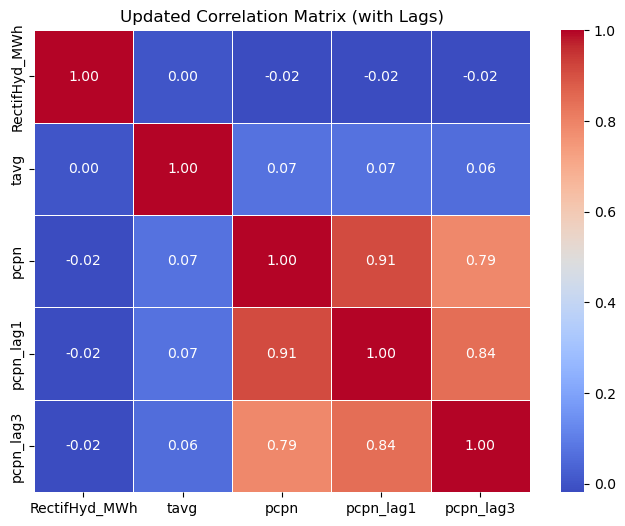

In [26]:
# ──────────────────────────────────────────────────────────────
# 4. UPDATED CORRELATION MATRIX & HEATMAP
# ──────────────────────────────────────────────────────────────
corr_cols = ['RectifHyd_MWh', 'tavg', 'pcpn', 'pcpn_lag1', 'pcpn_lag3']
corr = df[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Updated Correlation Matrix (with Lags)')
plt.show()